In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


In [3]:
# load metadata
metadata = pd.read_csv("../data/metadata.csv")

# Standardize emotion names
metadata["emotion"] = metadata["emotion"].str.lower()

# Map emotion → numeric label
emotion_map = {
    "angry": 0,
    "sad": 1,
    "happy": 2,
    "neutral": 3
}
metadata["emotion_label"] = metadata["emotion"].map(emotion_map)

# Map gender → numeric label
metadata["gender_label"] = metadata["gender"].map({"male": 0, "female": 1})

# Drop missing rows
metadata = metadata.dropna(subset=["emotion_label", "gender"])

metadata.head()


,filepath,emotion,gender,emotion_label,gender_label
0,../data/RADVESS/Actor_16/03-01-05-01-02-01-16.wav,angry,female,0,1
1,../data/RADVESS/Actor_16/03-01-05-02-01-01-16.wav,angry,female,0,1
2,../data/RADVESS/Actor_16/03-01-04-01-01-02-16.wav,sad,female,1,1
3,../data/RADVESS/Actor_16/03-01-04-02-02-02-16.wav,sad,female,1,1
4,../data/RADVESS/Actor_16/03-01-03-02-02-02-16.wav,happy,female,2,1


In [4]:
# mfcc extraction
def extract_mfcc(path):
    audio, sr = librosa.load(path, sr=16000)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)

    max_len = 200
    if mfcc.shape[1] < max_len:
        pad = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0,0),(0,pad)))
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc.T  # shape (200, 40)


In [5]:
# dataset class
class EmotionGenderDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = extract_mfcc(row["filepath"])
        return (
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(row["emotion_label"], dtype=torch.long),
            torch.tensor(row["gender_label"], dtype=torch.long)
        )

dataset = EmotionGenderDataset(metadata)
loader = DataLoader(dataset, batch_size=16, shuffle=True)


In [6]:
# load pretrained lstm basline model
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return h[-1]   # latent representation (64-dim)

# Load pretrained model from Stage C
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=64, output_dim=4):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

baseline = LSTMClassifier()
baseline.load_state_dict(torch.load("../models/lstm_baseline.pth"))
baseline.eval()

# Extract encoder weights
encoder = LSTMEncoder()
encoder.lstm.load_state_dict(baseline.lstm.state_dict())
encoder.train()

print("Loaded pretrained encoder.")


Loaded pretrained encoder.


In [7]:
# gradient reversal layer
class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

def grad_reverse(x, lambda_):
    return GradientReversal.apply(x, lambda_)


In [8]:
# emtion classifier head + gender adversary
class AdversarialModel(nn.Module):
    def __init__(self, encoder, hidden_dim=64, emotion_classes=4, gender_classes=2):
        super().__init__()
        self.encoder = encoder

        # Emotion prediction head
        self.emotion_head = nn.Linear(hidden_dim, emotion_classes)

        # Gender adversary head
        self.gender_head = nn.Linear(hidden_dim, gender_classes)

    def forward(self, x, lambda_):
        z = self.encoder(x)                    # latent representation
        emotion_logits = self.emotion_head(z)  # normal path
        rev = grad_reverse(z, lambda_)         # flipped gradient
        gender_logits = self.gender_head(rev)
        return emotion_logits, gender_logits


In [9]:
# initial model + loss + optimizer
model = AdversarialModel(encoder)

emotion_loss_fn = nn.CrossEntropyLoss()
gender_loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

lambda_adversary = 0.5   # strength of fairness constraint
epochs = 5


/Users/pc/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# training loop
for epoch in range(epochs):
    model.train()
    total_emotion_loss = 0
    total_gender_loss = 0

    for X, y_emotion, y_gender in loader:
        optimizer.zero_grad()

        e_logits, g_logits = model(X, lambda_adversary)

        loss_e = emotion_loss_fn(e_logits, y_emotion)
        loss_g = gender_loss_fn(g_logits, y_gender)

        loss = loss_e + loss_g
        loss.backward()
        optimizer.step()

        total_emotion_loss += loss_e.item()
        total_gender_loss += loss_g.item()

    print(f"Epoch {epoch+1}/{epochs} | Emotion Loss: {total_emotion_loss:.3f} | Gender Loss: {total_gender_loss:.3f}")

torch.save(model.state_dict(), "../models/lstm_adversarial.pth")
print("Saved adversarial model.")


Epoch 1/5 | Emotion Loss: 57.361 | Gender Loss: 29.137
Epoch 2/5 | Emotion Loss: 56.988 | Gender Loss: 29.108
Epoch 3/5 | Emotion Loss: 56.860 | Gender Loss: 29.117
Epoch 4/5 | Emotion Loss: 56.876 | Gender Loss: 29.110
Epoch 5/5 | Emotion Loss: 56.847 | Gender Loss: 29.125
Saved adversarial model.


In [11]:
# evaluate adverserial model
model.eval()
all_true = []
all_pred = []
all_gender = []

for X, y_emotion, y_gender in loader:
    with torch.no_grad():
        e_logits, _ = model(X, lambda_=0)
        preds = torch.argmax(e_logits, dim=1)

    all_true.extend(y_emotion.tolist())
    all_pred.extend(preds.tolist())
    all_gender.extend(y_gender.tolist())

acc = accuracy_score(all_true, all_pred)
f1 = f1_score(all_true, all_pred, average="weighted")

print("Debiased Model Accuracy:", acc)
print("Debiased Model F1:", f1)


Debiased Model Accuracy: 0.2857142857142857
Debiased Model F1: 0.12698412698412698


In [12]:
# gender bias metrics
df_eval = pd.DataFrame({
    "true": all_true,
    "pred": all_pred,
    "gender": all_gender
})

results = []
for g in [0, 1]:
    subset = df_eval[df_eval["gender"] == g]
    results.append({
        "gender": "male" if g==0 else "female",
        "accuracy": accuracy_score(subset["true"], subset["pred"]),
        "f1": f1_score(subset["true"], subset["pred"], average="weighted")
    })

bias_df = pd.DataFrame(results)
bias_df.to_csv("../results/adversarial_bias_metrics.csv", index=False)
bias_df


,gender,accuracy,f1
0,male,0.285714,0.126984
1,female,0.285714,0.126984


In [19]:


# comparison table
baseline_bias = pd.read_csv("../results/bias_summary.csv")

comparison = pd.DataFrame({
    "model": ["baseline", "adversarial"],
    "accuracy": [None, acc],
    "f1": [None, f1],
})

comparison.to_csv("../results/bias_comparison.csv", index=False)
comparison


,model,accuracy,f1
0,baseline,NaN,NaN
1,adversarial,0.288886,0.129505


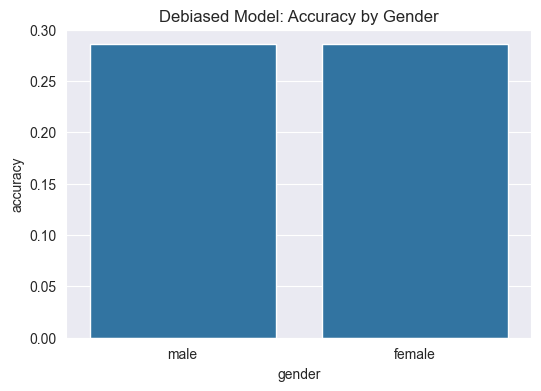

In [18]:
# bias gap visualization
plt.figure(figsize=(6,4))
sns.barplot(data=bias_df, x="gender", y="accuracy")
plt.title("Debiased Model: Accuracy by Gender")
plt.savefig("../results/adversarial_gender_gap.png", dpi=300, bbox_inches="tight")
plt.show()
